Import libraries

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import collections
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Load the dataset and split into Test, Validation and Train

In [57]:
# Load the IMDB Reviews dataset
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
train_data, test_data = imdb['train'], imdb['test']

# Validation set 
validation_size = int(0.2 * len(list(train_data)))

# Split the training data into training and validation sets
train_dataset = train_data.skip(validation_size)
validation_dataset = train_data.take(validation_size)

# Convert tensorflow dataset into lists for easier analysis
train_list = list(train_dataset.as_numpy_iterator())
validation_list = list(validation_dataset.as_numpy_iterator())
test_list = list(test_data.as_numpy_iterator())

# Label Distribution
train_labels = [label for _, label in train_list]
validation_labels = [label for _, label in validation_list]
test_labels = [label for _, label in test_list]

print(f"Training set size: {len(train_list)}")
print(f"Validation set size: {len(validation_list)}")  
print(f"Test set size: {len(test_list)}")

Training set size: 20000
Validation set size: 5000
Test set size: 25000


EDA

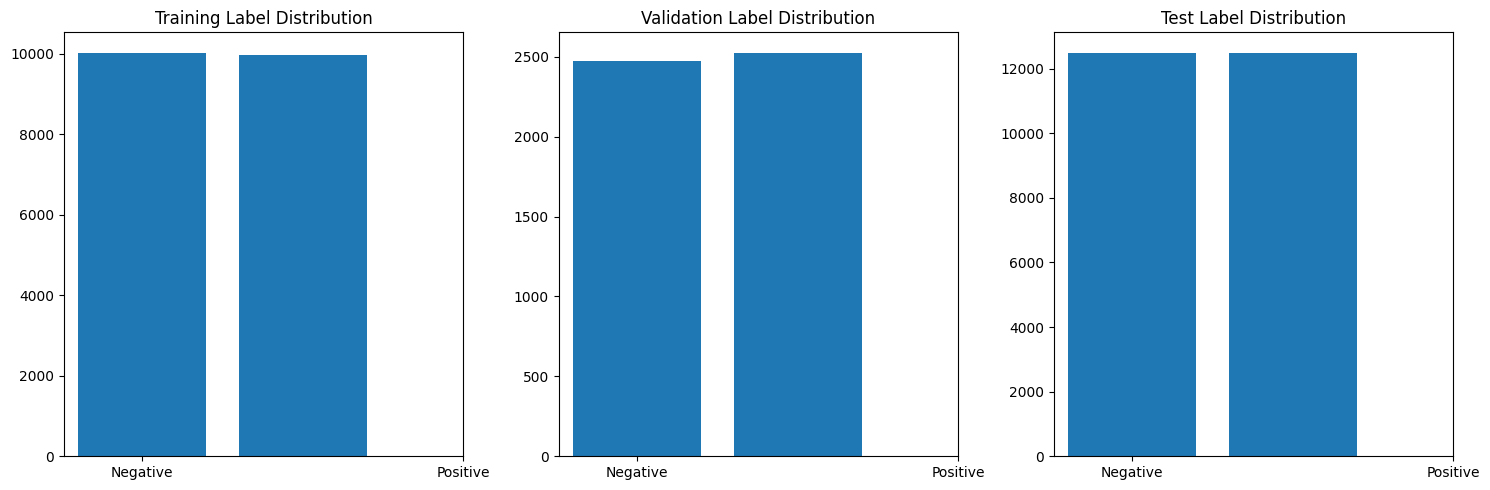

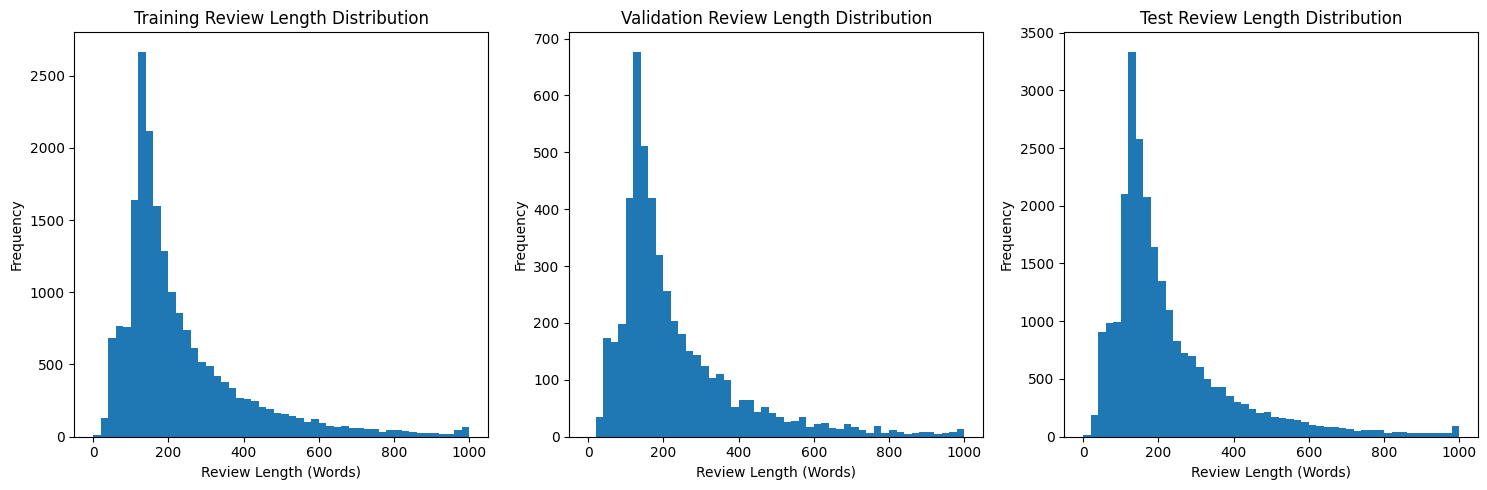


Average Training Review Length: 233.90 words
Average Validation Review Length: 233.35 words
Average Test Review Length: 228.53 words


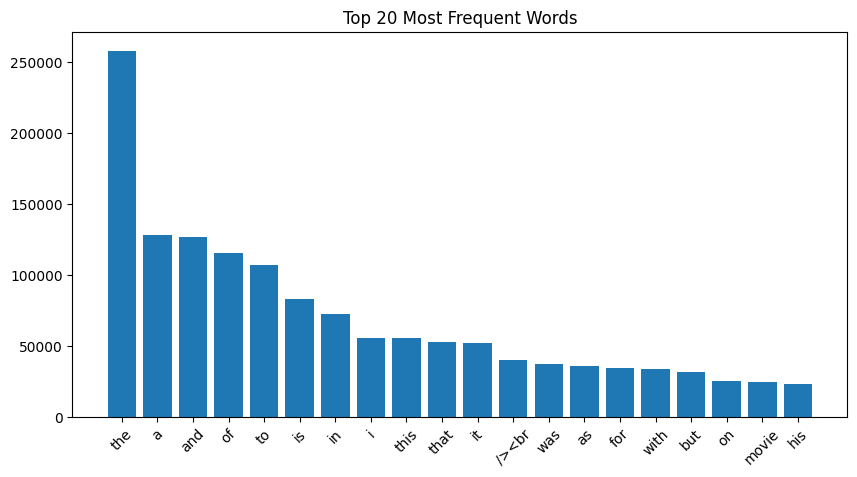

Average Word Length: 4.67
Unique Word Count: 219700
Review Length Standard Deviation: 173.50
Html tag count: 81191
Special character count: 1066364


In [58]:
# Label Distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_labels, bins=2, rwidth=0.8, align='left')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title('Training Label Distribution')

plt.subplot(1, 3, 2)
plt.hist(validation_labels, bins=2, rwidth=0.8, align='left')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title('Validation Label Distribution')

plt.subplot(1, 3, 3)
plt.hist(test_labels, bins=2, rwidth=0.8, align='left')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title('Test Label Distribution')

plt.tight_layout()
plt.show()

# Review Length Distribution
train_lengths = [len(text.decode('utf-8').split()) for text, _ in train_list]
validation_lengths = [len(text.decode('utf-8').split()) for text, _ in validation_list]
test_lengths = [len(text.decode('utf-8').split()) for text, _ in test_list]

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_lengths, bins=50, range=(0, 1000))
plt.title('Training Review Length Distribution')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(validation_lengths, bins=50, range=(0, 1000))
plt.title('Validation Review Length Distribution')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(test_lengths, bins=50, range=(0, 1000))
plt.title('Test Review Length Distribution')
plt.xlabel('Review Length (Words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Average Review Length
print(f"\nAverage Training Review Length: {np.mean(train_lengths):.2f} words")
print(f"Average Validation Review Length: {np.mean(validation_lengths):.2f} words")
print(f"Average Test Review Length: {np.mean(test_lengths):.2f} words")

# Word Frequency
all_words = []
for text, _ in train_list:
    all_words.extend(text.decode('utf-8').lower().split())

word_counts = collections.Counter(all_words)
top_words = word_counts.most_common(20)

words, counts = zip(*top_words)
plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words')
plt.show()

# Average Word Length
word_lengths = [len(word) for word in all_words]
avg_word_length = np.mean(word_lengths)
print(f"Average Word Length: {avg_word_length:.2f}")

# Unique Word Count
unique_word_count = len(set(all_words))
print(f"Unique Word Count: {unique_word_count}")

# Review Length Variability
review_length_std = np.std(train_lengths)
print(f"Review Length Standard Deviation: {review_length_std:.2f}")

# Special Character/HTML tag check.
html_tag_regex = re.compile(r'<[^>]+>')
special_char_regex = re.compile(r'[^a-zA-Z0-9\s]')

html_tag_count = 0
special_char_count = 0

for text, _ in train_list:
    decoded_text = text.decode('utf-8')
    html_tag_count += len(html_tag_regex.findall(decoded_text))
    special_char_count += len(special_char_regex.findall(decoded_text))

print(f"Html tag count: {html_tag_count}")
print(f"Special character count: {special_char_count}")

Text Preprocessing

In [ ]:
# Extract text and labels
train_sentences = [text.decode('utf-8') for text, _ in train_list]
train_labels = [label for _, label in train_list]

validation_sentences = [text.decode('utf-8') for text, _ in validation_list]
validation_labels = [label for _, label in validation_list]

test_sentences = [text.decode('utf-8') for text, _ in test_list]
test_labels = [label for _, label in test_list]

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(train_sentences)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# Padding
max_length = 200
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
validation_labels = np.array(validation_labels)
test_labels = np.array(test_labels)

# Convert numpy arrays to PyTorch tensors
train_data = torch.tensor(train_padded, dtype=torch.long)
train_labels = torch.tensor(train_labels, dtype=torch.float32).view(-1, 1)
validation_data = torch.tensor(validation_padded, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.float32).view(-1, 1)
test_data = torch.tensor(test_padded, dtype=torch.long)
test_labels = torch.tensor(test_labels, dtype=torch.float32).view(-1, 1)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(train_data, train_labels)
validation_dataset = TensorDataset(validation_data, validation_labels)
test_dataset = TensorDataset(test_data, test_labels)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Model definition

In [60]:
# Model Parameters
vocab_size = 10000
embedding_dim = 64
hidden_dim = 128
output_dim = 1
num_layers = 2
bidirectional = True

# Define the RNN Model (LSTM)
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        if bidirectional:
          hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
          hidden = hidden[-1,:,:]
        out = self.fc(hidden)
        return self.sigmoid(out)

# Instantiate the model
model = RNN(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, bidirectional)
model = model.to(device)

Training The model

In [67]:
#USe CUDA

train_data = train_data.to(device)
train_labels = train_labels.to(device)
validation_data = validation_data.to(device)
validation_labels = validation_labels.to(device)

# Loss function and optimizer (Same as before)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for batch_text, batch_labels in train_loader:
        batch_text = batch_text.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        predictions = model(batch_text)
        loss = criterion(predictions, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted_train = torch.round(predictions)
        correct_train += (predicted_train == batch_labels).sum().item()
        total_train += batch_labels.size(0)

    train_accuracy = correct_train / total_train
    avg_train_loss = total_loss / len(train_loader)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")


Epoch 1, Train Loss: 0.0080, Train Accuracy: 0.9977
Epoch 2, Train Loss: 0.0025, Train Accuracy: 0.9994
Epoch 3, Train Loss: 0.0003, Train Accuracy: 1.0000
Epoch 4, Train Loss: 0.0001, Train Accuracy: 1.0000
Epoch 5, Train Loss: 0.0000, Train Accuracy: 1.0000
Epoch 6, Train Loss: 0.0000, Train Accuracy: 1.0000
Epoch 7, Train Loss: 0.0000, Train Accuracy: 1.0000
Epoch 8, Train Loss: 0.0000, Train Accuracy: 1.0000
Epoch 9, Train Loss: 0.0000, Train Accuracy: 1.0000
Epoch 10, Train Loss: 0.0000, Train Accuracy: 1.0000


Validation Execution

In [68]:
model.eval()
validation_loss = 0
correct_val = 0
with torch.no_grad():
    for batch_text, batch_labels in validation_loader:
        batch_text = batch_text.to(device)
        batch_labels = batch_labels.to(device)
        predictions = model(batch_text)
        validation_loss += criterion(predictions, batch_labels).item()
        predicted_val = torch.round(predictions)
        correct_val += (predicted_val == batch_labels).sum().item()

val_accuracy = correct_val / len(validation_loader.dataset)
print(f"Validation Loss: {validation_loss/len(validation_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

Validation Loss: 1.9886, Validation Accuracy: 0.8544


Test execution

In [69]:
#  Data to device
test_data = test_data.to(device)
test_labels = test_labels.to(device)

model.eval()
test_loss = 0
correct_test = 0
with torch.no_grad():
    for batch_text, batch_labels in test_loader:
        batch_text = batch_text.to(device)
        batch_labels = batch_labels.to(device)
        predictions = model(batch_text)
        test_loss += criterion(predictions, batch_labels).item()
        predicted_test = torch.round(predictions)
        correct_test += (predicted_test == batch_labels).sum().item()

test_accuracy = correct_test / len(test_loader.dataset)
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 2.2213, Test Accuracy: 0.8370
